In [1]:
import deorbit
import numpy as np
import matplotlib.pyplot as plt
from deorbit.observer import Observer
from tqdm import tqdm

In [2]:
# Running simulator
sim = deorbit.simulator.run(
    "adams_bashforth",
    "coesa_atmos_fast",
    initial_state=np.array((deorbit.constants.EARTH_RADIUS + 150000, 0, 0, 7820)),
    time_step=0.1,
)

Running simulation with Two-step Adams-Bashforth integrator without noise
Ran 262728 iterations at time step of 0.1 seconds
Impacted at [ 6168983.59022696 -1591617.34648274] at velocity [-48.10422636  12.41104308] at simulated time 26272.89999989817s.
Simulation finished in 10.72383 seconds


In [3]:
#initialising observer class with sim data
obs = Observer(number_of_radars=3)


ValueError: latitude must be between -pi/2 and pi/2

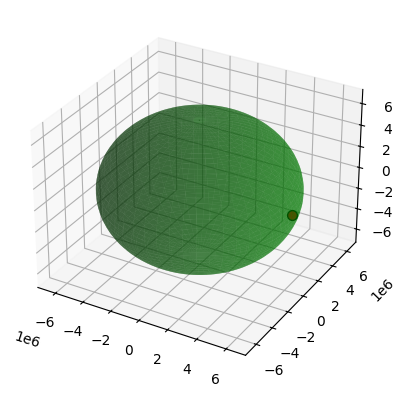

In [4]:
#can plot the radar location
obs.plot_config()

In [ ]:
#or can print their coordinates, in longitude/latitudes in radians
print(obs.positions_of_radars)

[[0.        0.       ]
 [2.0943951 0.       ]
 [4.1887902 0.       ]]


In [ ]:
#this runs every 10 time steps of the sim data 
obs.run(sim.times, sim.states, 5000)

print(len(obs.observed_times))


11


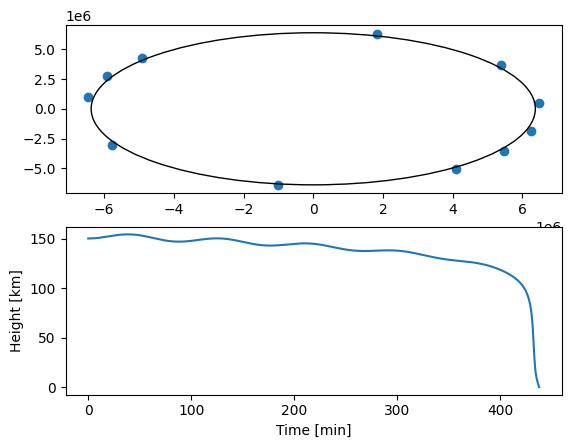

In [ ]:
obs_states = obs.observed_states

states = np.array(sim.states)

fig, (ax, ax1) = plt.subplots(2, 1)

ax.scatter(obs_states[:, 0], obs_states[:, 1])
earth = plt.Circle((0, 0), radius=deorbit.constants.EARTH_RADIUS, fill=False)
ax.add_patch(earth)

ax1.plot(np.array(sim.times) / 60, (np.linalg.norm(states[:, :2], axis=1) - deorbit.constants.EARTH_RADIUS)/1000)
ax1.set_ylabel("Height [km]")
ax1.set_xlabel("Time [min]")

plt.show()

In [ ]:
radar_list = np.arange(1, 30)
satellite_visibility = []
for i in tqdm(radar_list):
    obs = Observer(number_of_radars=i)

    obs.run(sim.times, sim.states, 10)

    observation_times = obs.observed_times

    satellite_visibility.append((len(observation_times)/len(sim.times))*100)


  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [02:55<00:00,  6.05s/it]


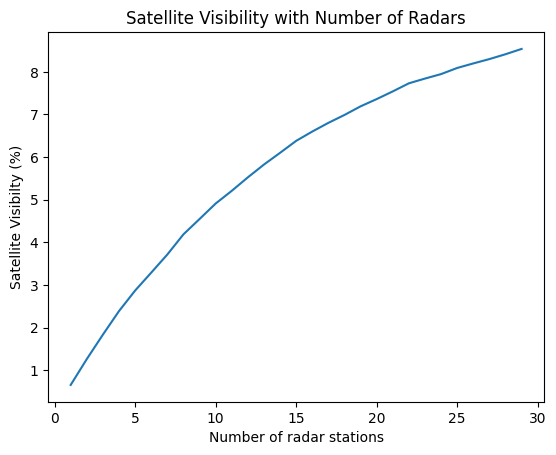

In [ ]:
fig, ax = plt.subplots()

ax.plot(radar_list, satellite_visibility)
ax.set_title('Satellite Visibility with Number of Radars')
ax.set_xlabel('Number of radar stations')
ax.set_ylabel('Satellite Visibilty (%)')
plt.show()

#should plateau to 10% so looks good